In [33]:
import sys
print(sys.executable)


/opt/anaconda3/envs/COMP647_env_py312/bin/python


- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 02/09/2025

# Project Plan

- Columns to keep or drop
    - Columns to keep are: "uniq_id", "product_name", "price", "number_available_in_stock", "number_of_reviews", "average_review_rating", "amazon_category_and_sub_category", "product_information", "customer_reviews" and "seller".
    - I will drop "manufacturer" because it contains too much random and inaccurate information, such as numbers or repeated words from the product name, which makes it impossible to clean. 
    - I will drop "number_of_answered_questions" since the numbers don’t give any meaningful insight (the actual questions are unknown).
    - I will drop "customers_who_bought_this_item_also_bought" and "items_customers_buy_after_viewing_this_item" because they only contain product web links, and most of them are likely invalid as the dataset is quite old.
    - I will drop "description" and "product_description" because they are long paragraphs with similar content, and it is hard to extract clear, representative keywords from them.
    - I will drop "customer_questions_and_answers" because only 914 out of 10,000 rows are filled, and the filled ones contain long paragraphs that are difficult to handle.

- Clean data 
    - For "price", remove symbols before the number.
    - For "number_available_in_stock", split into two columns: "stock_quantity" and "stock_status".
    - From "average_review_rating", extract the numeric part into a new column called "average_rating".
    - For "amazon_category_and_sub_category", split into two levels only, and label them "main_category" and "sub_category".
    - From "product_information", extract product weight (e.g., values like weight…g or weight…kg) into a new column called "product_weight".
    - For "product_weight":
        - extract only numbers and g/kg,
        - convert all g values into kg,
        - remove the unit (e.g., kg).
    - From "product_information", also extract age suitability (e.g., age…up) into a new column called "age_suitability", and keep only the numeric part.
    - From "customer_reviews", extract the first date into a new column called "purchase_date" (assuming reviews were made in the same month as purchase).
    - From "seller", extract only the seller name.
    - Fix the data type for each feature.
    - For all string columns, use .strip() to remove leading and trailing spaces.
    - Drop the original features after transformation.


- Transform data
    - Filling missing value
        - For categories, use "Unknown main category" and "Unknown sub category".
        - For "price", fill with the average price of the same sub_category.
        - For "stock_quantity", fill with the mode of the same sub_category.
        - For "stock_status", fill with the mode of the same sub_category.
        - For "product_weight", fill with the median of the same sub_category.
        - For "age_suitability", fill with the mode of the same sub_category.
        - For "purchase_date", fill with the mode of the same sub_category.
        - For "number_of_reviews", fill with the mode of the same sub_category.
        - For "average_rating", fill with the average rating of the same sub_category.
        - For "seller", fill with "Unknown seller".


- Visualise data
    - Filter data to only:
        - number_of_reviews>=51
        - average rating>=4.5
    - Produce a scatter plot where x="number_of_reviews" y="average rating" and hue="top category"

# Research Question

As an entrepreneur who wants to start a business on amazon.com, if I assume that higher product ratings correspond to better sales performance, then:
- Which main product category tends to receive a higher response rate and higher ratings?
- Which sub category within that main category has a higher response rate and higher ratings?
- Which seller has most products to sell?
- Which main category product is receiving has highest ratings and doesn't cost that much for stocking?
- What is the item quantity I should at least prepare?

As a buyer, I want to know:
- For the same product, which seller is selling at a cheaper price?
- Which seller received more high ratings for their product?

As a company, I want to know:
- Which month of the year made most sale. 
- Compare sales across the years to discover which year made the highest gross profit and mainly from which category of products.

# Import the Necessary Libraries for Data Cleaning

In [34]:
import numpy as np # Numerical operations and array handling.
import pandas as pd # Data manipulation and analysis.
import matplotlib.pyplot as plt # Plotting library for creating static, animated, and interactive visualizations.
import seaborn as sns # Statistical data visualization library based on matplotlib.
from scipy import stats # Module for scientific computing, including statistical functions.


# Read Data from CSV

Data source: [Fashion products on Amazon.com](https://www.kaggle.com/datasets/hkhamnakhalid/fashion-products-on-amazoncom)

In [35]:
file_path = 'amazon_co-ecommerce_sample.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path) # Read the csv file into a DataFrame.

# Understand Data

In [36]:
df[df.groupby('product_name')['product_name'].transform('count') > 1] 
# The .groupby function allows to aggregate the data occurance. 
# The .transform('count') > 1 will call out data under the product name occur more than once.
# The intention of this move

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
71,1e9876e6f7e98a6bb869341b4b56efd5,Power Trains Auto Loader City,POWER CITY TRAINS,£76.99,2 new,NaN,1.0,NaN,NaN,http://www.amazon.co.uk/Power-Trains-Auto-Load...,Power City Trains Auto Loader City,Technical Details Item Weight1.5 Kg Product Di...,Power City Trains Auto Loader City,http://www.amazon.co.uk/Power-Trains-Auto-Load...,NaN,NaN,"{""seller""=>[{""Seller_name_1""=>""Eurozone Market..."
411,b585918cbbf998a288bbb259313f0296,Polyhedral Dice,Chessex,£11.93,4 new,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/Polyhedral,Signature dice are a compilation of the best s...,Technical Details Item Weight54 g Product Dime...,Signature dice are a compilation of the best s...,NaN,NaN,RPG-tastic! // 5.0 // 21 April 2013 // By\n ...,NaN
441,47e284cab850f3a73f412ed5fe85d969,"100 six sided dice, 14mm, random colours",The Dice Place,£10.79,NaN,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/Chessex-Dice-Pound-Pou...,A pack of 100 (minimum) dice useful for many b...,Technical Details Item Weight277 g Product Dim...,A pack of 100 (minimum) dice useful for many b...,http://www.amazon.co.uk/sided-dice-16mm-random...,NaN,Five Stars // 5.0 // 19 Feb. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""Legendgames"", ""S..."
471,b5b9d9641ddd0c677c5ddaa719207f63,Polyhedral Dice,Chessex,£9.74,2 new,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/WHATWEARS-Poly-Dices-P...,NaN,Technical Details Item Weight54 g Manufacturer...,NaN,NaN,NaN,"Good design and good quality, would recommend....",NaN
585,222285fb1f28be6b3d6d14d5c35e562f,"100 six sided dice, 14mm, random colours",The Dice Place,£10.79,NaN,2,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/spot-12mm-diameter-ass...,A pack of 100 (minimum) dice useful for many b...,Technical Details Item Weight277 g Product Dim...,A pack of 100 (minimum) dice useful for many b...,http://www.amazon.co.uk/spot-12mm-diameter-ass...,NaN,I now have want more // 5.0 // 7 Mar. 2013 // ...,"{""seller""=>{""Seller_name_1""=>""Legendgames"", ""S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,0046d3f852f55ee28b4a049ed387a946,Orchard Toys Farmyard Dominoes,Orchard Toys,£7.99,21 new,19,5.0,4.8 out of 5 stars,Games > Educational Games,http://www.amazon.co.uk/Orchard-Toys-28-Farm-S...,Product Description This is the familiar game ...,Technical Details Item Weight572 g Product Dim...,Product Description This is the familiar game ...,http://www.amazon.co.uk/Orchard-Toys-Old-MacDo...,NaN,brilliant // 5.0 // 15 May 2012 // By\n \n ...,"{""seller""=>[{""Seller_name_1""=>""Atrad"", ""Seller..."
9449,0cf2e89e32c4729f71647e876cbb5dec,20Q,Mattel,NaN,NaN,34,1.0,4.4 out of 5 stars,Electronic Toys > Educational Computers & Acce...,http://www.amazon.co.uk/An-Astronauts | http:/...,Product Description I have mixed the bar-codes...,Technical Details Item Weight222 g Product Dim...,Product Description I have mixed the bar-codes...,http://www.amazon.co.uk/Radica-I4012-20Q/dp/B0...,does the ball talk? // No displays answer on s...,I beg to differ // 4.0 // 27 Oct. 2010 // By\n...,NaN
9467,b7fb4625845f84ffc5b34fdc27189587,20Q,Radica,NaN,2 new,102,1.0,4.5 out of 5 stars,Games > Trivia & Quiz Games,http://www.amazon.co.uk/Radica-I6088-20Q-Versi...,Product Description I can read your mind! Manu...,Technical Details Item Weight91 g Product Dime...,Product Description I can read your mind! Manu...,http://www.amazon.co.uk/Radica-I6088-20Q-Versi...,NaN,"Great, but a little bit spooky!! // 5.0 // 21 ...","{""seller""=>[{""Seller_name_1""=>""Smaller Worl

In [37]:
# Use DataWrangler to understand data quality issues. 
# This extension helps to identify missing values, duplicates, and other data quality issues by providing a summary and displaying data in a table format.
df.head(1)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."


# Keep Useful Columns Only

### All Columns in DataFrame

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      10000 non-null  object 
 1   product_name                                 10000 non-null  object 
 2   manufacturer                                 9993 non-null   object 
 3   price                                        8565 non-null   object 
 4   number_available_in_stock                    7500 non-null   object 
 5   number_of_reviews                            9982 non-null   object 
 6   number_of_answered_questions                 9235 non-null   float64
 7   average_review_rating                        9982 non-null   object 
 8   amazon_category_and_sub_category             9310 non-null   object 
 9   customers_who_bought_this_item_also_bought   8938 non-null   object 
 10 

### All Columns in Cleaned DataFrame

In [39]:
cleaned_df=df[[
    'uniq_id',
    'product_name',
    'price',
    'number_available_in_stock',
    'number_of_reviews',
    'average_review_rating',
    'amazon_category_and_sub_category',
    'product_information',
    'customer_reviews',
    'sellers']]

In [40]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   uniq_id                           10000 non-null  object
 1   product_name                      10000 non-null  object
 2   price                             8565 non-null   object
 3   number_available_in_stock         7500 non-null   object
 4   number_of_reviews                 9982 non-null   object
 5   average_review_rating             9982 non-null   object
 6   amazon_category_and_sub_category  9310 non-null   object
 7   product_information               9942 non-null   object
 8   customer_reviews                  9979 non-null   object
 9   sellers                           6918 non-null   object
dtypes: object(10)
memory usage: 781.4+ KB


# Reformat Columns

## Remove Symbols in "price" Column

In [41]:
# Although it is obvious that this column contains money symbol, but it could also contain other characters that I oversee. 
# So, instead of droping the things I don't want, I will extract the things I want.

cleaned_df['cleaned_price'] = (
    cleaned_df['price']
    .astype(str)  # change the datatype to string
    .str.extract(r'(\d+\.\d+|\d+)')  # From the string, extract only the numeric vaules using regular expression
    #(r'\d+\.\d+|\d+') this regex pattern matches both integer and decimal numbers.
    .astype(float) )

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/2785400651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['cleaned_price'] = (


In [42]:
cleaned_df.info()
cleaned_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
dtypes: float64(1), object(10)
memory usage: 859.5+ KB


,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99


## Extract Numerical Data from "average_review_rating" and Correct Data Type

In [43]:
cleaned_df['average_review_rating_out_of_5'] = (# Create a new column 'average_rating_out_of_5.0' in cleaned_df for cleaned average review ratings.
    cleaned_df['average_review_rating'] 
    .astype(str) # Convert to string to handle any NaNs, as explained in the previous steps.
    .str.extract(r'(\d+\.\d+|\d+)', expand=False)  
    # (\d+ extracts one or more digits. Eg: '123', '4567', '89'.
    # \.\d+ extracts a decimal point followed by one or more digits. Eg: '3.5', '4.0', '2.75'.
    # | extracts ither an integer (\d+) or a float (\d+\.\d+).
    # expand=False ensures that the result is a Series, not a DataFrame. Eg: '123.45' will be extracted as a single value, not as 1, 2, 3 . 4 and 5 in individual columns.
    .astype(float)
 ) # Convert to float.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/3933719750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['average_review_rating_out_of_5'] = (# Create a new column 'average_rating_out_of_5.0' in cleaned_df for cleaned average review ratings.


In [44]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  average_review_rating_out_of_5    9982 non-null   float64
dtypes: fl

## Split Product Hierachy for "amazon_category_and_sub_category" Column


In [45]:
# The reason to keep two levels of the hierachy only is because many of the category level stopped after two levels. 

cleaned_df[['main_category', 'sub_category']] = (
    df['amazon_category_and_sub_category']
    .str.split('>', expand=True)[[0, 1]])
# The .str.split('>') function splits the string into a list of substrings based on the '>'.
# The expand=True function specifies the split data to expand to its new column, not within the original column. 
# The [[0,1]] function specifies to select the first and second from the hierachy list only.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/127122190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[['main_category', 'sub_category']] = (
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/127122190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[['main_category', 'sub_category']] = (


In [46]:
cleaned_df.info()
# The row count of the two new columns are same as the original. This means good.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  average_review_rating_out_of_5    9982 non-null   float64
 12  main_

In [47]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,average_review_rating_out_of_5,main_category,sub_category
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,4.9,Hobbies,Model Trains & Railway Sets
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,4.5,Hobbies,Model Trains & Railway Sets
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,3.9,Hobbies,Model Trains & Railway Sets


In [48]:
print(cleaned_df['main_category'].value_counts(dropna=False)) 
# This function allows me to see the count of each category, including the missing value.

main_category
Hobbies                              1464
Die-Cast & Toy Vehicles              1221
Figures & Playsets                   1111
Characters & Brands                   960
Games                                 941
Arts & Crafts                         802
Party Supplies                        694
NaN                                   690
Fancy Dress                           585
Sports Toys & Outdoor                 372
Dolls & Accessories                   371
Jigsaws & Puzzles                     274
Puppets & Puppet Theatres             269
Baby & Toddler Toys                   106
Pretend Play                           45
Musical Toy Instruments                19
Novelty & Special Use                  11
Pens, Pencils & Writing Supplies        7
Office Supplies                         6
Electronic Toys                         5
Home Accessories                        5
Bags                                    4
Cooking & Dining                        4
Educational Toys    

In [49]:
print(cleaned_df['sub_category'].value_counts(dropna=False)) 

sub_category
 Toy Vehicles & Accessories          1100
NaN                                   690
 Science Fiction & Fantasy            485
 Accessories                          388
 Model Trains & Railway Sets          386
                                     ... 
 Transportation & Traffic               1
 Specialty & Decorative Lighting        1
 Instruments                            1
 Trading Cards & Accessories            1
 Drinking Games                         1
Name: count, Length: 166, dtype: int64


## Extract Values from "product_information" Column

### Extract Item Weight

In [50]:
# This column has a lot of mixed information, but I only want to extract two things. They are the item weight (for logistics) and the recommended age (for buyer reference).

cleaned_df['item_weight'] = cleaned_df['product_information'].str.extract(r'Item Weight\s*([\d\.]+\s*(?:g|Kg))', 
    expand=False)

# Regular expression is used to exract the item weight, with \s* allows for space between the word item and weight.
# ([\d\.]+ specifies extracting value with one or more digits or decimal point.
# \s* allows for space after the value.
# (?:g|Kg) specifies the unit can either be g or kg.
# The entire expression within the bracket indicates to only return the weight value plus unit.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/1967455311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['item_weight'] = cleaned_df['product_information'].str.extract(r'Item Weight\s*([\d\.]+\s*(?:g|Kg))',


In [51]:
# I want the unit within the column to be consistent for better data reviewing. 

def convert_to_kg(value): # This def instruction defines what I want python to do with "convert_to_kg".
    if pd.isna(value):  # if value is missing, just return NaN
        return None
    value = value.strip() 
    if value.endswith("Kg"): # if values end with kg
        return float(value.replace("Kg", "").strip()) # return only a decimal value and replace the kg with whitespace.
    elif value.endswith("g"): # if values ends with g
        return float(value.replace("g", "").strip()) / 1000 # return only a decimal value that divided by 1000 and replace the g with whitespace.
    else:
        return None
    
cleaned_df['item_weight'] = cleaned_df['item_weight'].apply(convert_to_kg)
# By applying the defined instruction that has been explained to python, I want it to apply this expression to the "item_weight" column to remove the unit and make everything numeric in kilograms.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/1765398044.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['item_weight'] = cleaned_df['item_weight'].apply(convert_to_kg)


In [52]:
# Rename the column to reflect the unit.
cleaned_df.rename(columns={'item_weight': 'item_weight_in_kg'}, inplace=True)

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/237502366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.rename(columns={'item_weight': 'item_weight_in_kg'}, inplace=True)


In [53]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,4.9,Hobbies,Model Trains & Railway Sets,0.64
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,4.5,Hobbies,Model Trains & Railway Sets,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,3.9,Hobbies,Model Trains & Railway Sets,NaN


### Extract Recommended Age

In [54]:
# First, extract the manufacturer recommended age from the product_information column.

age_extracted = cleaned_df['product_information'].str.extract(
    r'Manufacturer recommended age:(\d+)\s*(years|months)',
    expand=True)  


In [55]:
age_value = pd.to_numeric(age_extracted[0], errors='coerce')
age_unit = age_extracted[1]

In [56]:
cleaned_df['recommended_minimum_age_years'] = np.where(
    age_unit == 'months',
    age_value / 12,   # months → years
    age_value).round(2)  # already in years


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/3005929257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['recommended_minimum_age_years'] = np.where(


In [57]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,4.5,Hobbies,Model Trains & Railway Sets,NaN,3.0
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,3.9,Hobbies,Model Trains & Railway Sets,NaN,3.0


## Apply Strip () to All Str Type Columns

In [58]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  average_review_rating_out_of_5    9982 non-null   float64
 12  main_

In [59]:
for col in cleaned_df.select_dtypes(include='object').columns:
    cleaned_df[col] = cleaned_df[col].str.strip()

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/3491162696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = cleaned_df[col].str.strip()


## Drop Original Columns

In [60]:
cleaned_df.drop(columns=['average_review_rating','amazon_category_and_sub_category'], inplace=True)  # Drop the original column after extracting the main category.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_7075/648916161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=['average_review_rating','amazon_category_and_sub_category'], inplace=True)  # Drop the original column after extracting the main category.


In [61]:
cleaned_df.info()
cleaned_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   price                           8565 non-null   object 
 3   number_available_in_stock       7500 non-null   object 
 4   number_of_reviews               9982 non-null   object 
 5   product_information             9942 non-null   object 
 6   customer_reviews                9979 non-null   object 
 7   sellers                         6918 non-null   object 
 8   cleaned_price                   8565 non-null   float64
 9   average_review_rating_out_of_5  9982 non-null   float64
 10  main_category                   9310 non-null   object 
 11  sub_category                    9310 non-null   object 
 12  item_weight_in_kg               7

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,product_information,customer_reviews,sellers,cleaned_price,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0


# Filling Missing Values

## Fill in Missing Values for 'amazon_category'

In [62]:
cleaned_df['amazon_category'] = cleaned_df['amazon_category'].fillna('Unknown') # fillna() replaces NaN values with 'Unknown'.

KeyError: 'amazon_category'

In [ ]:
cleaned_df.head(1)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,product_information,customer_reviews,sellers,average_review_rating_out_of_5,amazon_category
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",4.9,Hobbies


## Fill in Missing Values for 'average_review_rating_out_of_5'

In [ ]:
cleaned_df['average_review_rating_out_of_5'] = (
    cleaned_df.groupby('amazon_category')['average_review_rating_out_of_5'] # .groupby() groups the DataFrame by 'amazon_category'and 'average_review_rating_out_of_5' columns.
    .transform(lambda x: x.fillna(x.mean())) # .transform() applies a function to each group, filling NaN values with the mean of the group.
    # lambda x: x.fillna(x.mean()) calculates the mean of the group and fills NaN values with that mean.
).round(1) # .round(1) rounds the values to one decimal place.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_1444/4203628704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['average_review_rating_out_of_5'] = (


In [ ]:
cleaned_df.head(1)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,product_information,customer_reviews,sellers,average_review_rating_out_of_5,amazon_category
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",4.9,Hobbies


## Fill in Missing Values for 'number_of_reviews'

In [ ]:
cleaned_df['number_of_reviews'] = pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce')
# pd.to_numeric() converts values to numbers, and anything invalid (like strings or symbols) becomes NaN.
# errors='coerce' ensures that any non-numeric values are converted to NaN instead of raising an error.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_1444/96151733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['number_of_reviews'] = pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce')


In [ ]:
cleaned_df['number_of_reviews'] = (
    cleaned_df.groupby('amazon_category')['number_of_reviews']
    .transform(lambda x: x.fillna(x.mode())) # .transform() applies a function to each categorical group, filling NaN values with the mode of the group.
    # lambda x: x.fillna(x.mode()) calculates the mode of the group and fills NaN values with that mode.
)

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_1444/597056016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['number_of_reviews'] = (


In [ ]:
cleaned_df.head(1)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,product_information,customer_reviews,sellers,average_review_rating_out_of_5,amazon_category
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15.0,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",4.9,Hobbies


In [ ]:
cleaned_df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   price                           8565 non-null   object 
 3   number_available_in_stock       7500 non-null   object 
 4   number_of_reviews               9980 non-null   float64
 5   product_information             9942 non-null   object 
 6   customer_reviews                9979 non-null   object 
 7   sellers                         6918 non-null   object 
 8   average_review_rating_out_of_5  10000 non-null  float64
 9   amazon_category                 10000 non-null  object 
dtypes: float64(2), object(8)
memory usage: 781.4+ KB


# Visualise Data

In [ ]:
cleaned_df_filtered = cleaned_df[
    (cleaned_df['average_review_rating_out_of_5'] > 4.5) &
    (pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce').fillna(0).astype(int) >= 51)
]

: 

In [ ]:
cleaned_df['number_of_reviews'].value_counts().describe()
# .value_counts() counts the occurrences of each unique value in the 'number_of_reviews' column.
# .describe() provides a summary of statistics for the counts, including count, mean, standard deviation, min, max, and quartiles.

count     192.000000
mean       51.979167
std       334.687210
min         1.000000
25%         1.000000
50%         2.000000
75%         9.000000
max      4315.000000
Name: count, dtype: float64

In [ ]:
cleaned_df_filtered['review_bins'] = pd.cut(
    cleaned_df_filtered['number_of_reviews'],
    bins=[0, 10, 25, 50, 100, 250, 500, 1000, float('inf')], # bins = [] will sort values into bins. The .float('inf') will sort all values beyond the last bin.
    labels=['1-10', '11-25', '26-50', '51-100', '101-250', '251-500', '501-1000', '1000+']) # 8 labels are created becuase the number of label must be one less than bin. 
    # These labels will group numbers into ranges.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_1444/2958708628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_filtered['review_bins'] = pd.cut(


In [ ]:
cleaned_df_filtered['review_bins'] = pd.cut( # pd.cut() is a function used to group numeric values into categories (bins).
    cleaned_df_filtered['number_of_reviews'],
    bins=[0, 10, 25, 50, 100, 250, 500, 1000, float('inf')], # Define ranges.
    labels=['1-10', '11-25', '26-50', '51-100', '101-250', '251-500', '501-1000', '1000+'], # Assign names to those ranges.
    include_lowest=True # Ensures values equal to the lowest bin (i.e., 0) are included
)

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_1444/866519659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_filtered['review_bins'] = pd.cut( # pd.cut() is a function used to group numeric values into categories (bins).


In [ ]:
top_categories = cleaned_df_filtered['amazon_category'].value_counts().nlargest(10).index
# .value_counts, will count how many times each category appears (i.e., frequency of each category)
# .nlargest(10), will grab the top 10 categories with the most records.
# .index, will return just the category names (i.e., only the labels, not the counts)


df_top = cleaned_df_filtered[cleaned_df_filtered['amazon_category'].isin(top_categories)]


In [ ]:
bins_to_keep = ['51-100', '101-250', '251-500', '501-1000', '1000+']

df_top_filtered = df_top[df_top['review_bins'].isin(bins_to_keep)].copy()

df_top_filtered['review_bins'] = pd.Categorical(
    df_top_filtered['review_bins'],
    categories=bins_to_keep,
    ordered=True 
)


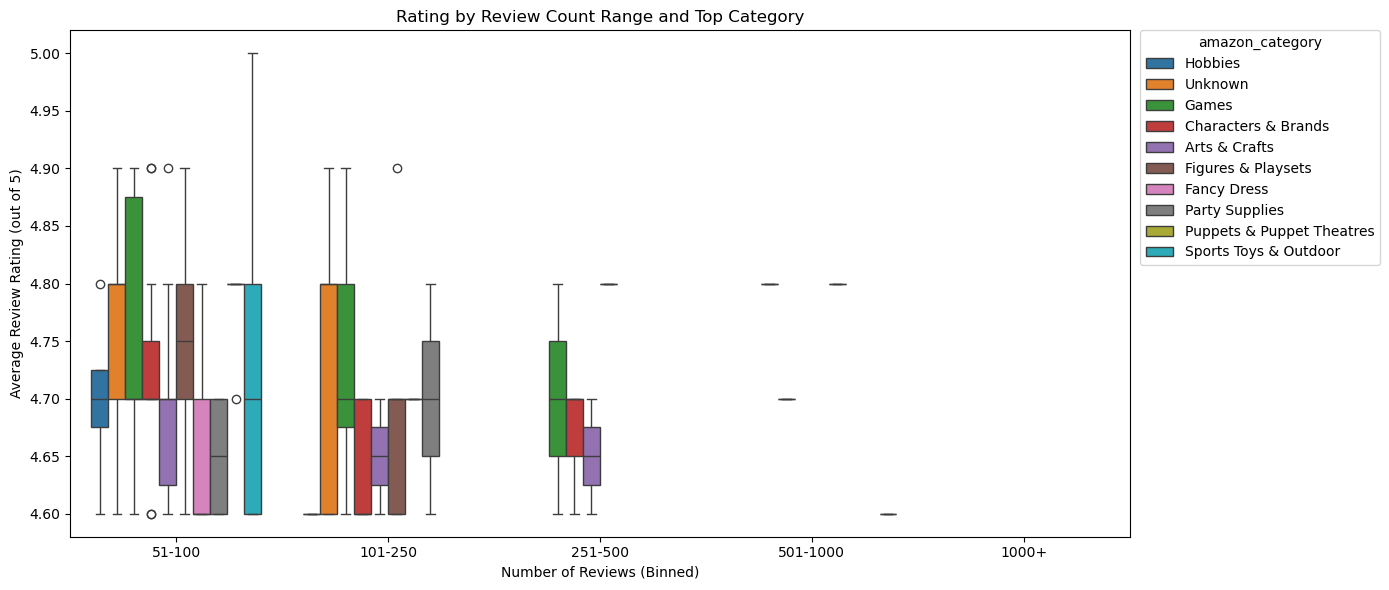

In [ ]:

#sns.scatterplot(
    #data=df_top_filtered,
    #x="review_bins",
    #y="average_review_rating_out_of_5",
    #style="amazon_category",
#)

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_top_filtered,
    x="review_bins",
    y="average_review_rating_out_of_5",
    hue="amazon_category",
    dodge=True, # This code ensures the review bin gets its own separate box, side by side, not overlapping each other.
    width=0.8 
)


plt.legend(
    title="amazon_category",
    bbox_to_anchor=(1.01, 1),  # Place legend outside the axes
    loc='upper left',
    borderaxespad=0 # Space between the legend and the graph
)

plt.title("Rating by Review Count Range and Top Category")
plt.xlabel("Number of Reviews (Binned)")
plt.ylabel("Average Review Rating (out of 5)")
plt.tight_layout()  # Prevent label/legend cutoff
plt.show()


# Answer to the Research Question
 - I should sell products in the Games category, as most items in this category receive high response rates and optimal ratings.